# Dependencies:
```Click to view session information
-----
PIL                 10.1.0
matplotlib          3.8.1
numpy               1.24.3
session_info        1.0.0
spectral            0.23.1
-----
Click to view modules imported as dependencies
-----
IPython             8.17.2
jupyter_client      8.5.0
jupyter_core        5.5.0
-----
Python 3.9.6 (default, Feb  3 2024, 15:58:27) [Clang 15.0.0 (clang-1500.3.9.4)]
macOS-14.5-arm64-arm-64bit
-----
Session information updated at 2024-07-09 15:03

-----
PIL                 11.0.0
cv2                 4.10.0
matplotlib          3.9.2
numpy               2.1.3
session_info        1.0.0
spectral            0.23.1
-----
Click to view modules imported as dependencies
-----
IPython             8.29.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
macOS-14.7.1-arm64-arm-64bit
-----
Session information updated at 2024-11-25 16:03

# **Goals:**
1. Divide images into patches 
2. Pull spectrums from each patch

### Notes:
- Steps 1-4 are defining and testing functions 
- Steps 5-7 will need to be performed in each folder

In [2]:

import session_info
import spectral.io.envi as envi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import csv
import os

session_info.show()

# **Steps 1-4 are for processing single images and defining funcitons**
# **Step 1:** Read in .Float File and Convert to numpy array

In [62]:
def Float2NPY(HDRpath, FloatPath, CroppedPNGDirectory):
    img = envi.open(HDRpath, FloatPath)
    #convert to .npy
    npy = img[:,:,:]

    # Find Encolosing folder (category)
    split = FloatPath.split('/')
    category = split[-2] + ' ' + split[-1]

    PNGName = split[-1][:-5] + 'png'
    PNGPath = CroppedPNGDirectory + '/' + PNGName
    return npy, category, PNGPath

HDRpath = "/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 1 float.hdr"
FloatPath = "/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 1 float.float"
CroppedPNGDirectory = "/Users/maycaj/Documents/HSI_III/EdemaFalse"
PNGpath = '/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 1 float.png'


In [57]:

npy, category, PNGPath = Float2NPY(HDRpath, FloatPath, CroppedPNGDirectory)
npy.shape, category, PNGPath
category, PNGPath

('EdemaFalse EDema 021 image 1 float.float',
 '/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 1 float.png')

# **Step 2:** Save the npy array as a .png

In [34]:
def npy2png(npy, PNGpath):
    red = npy[:,:,20]
    green = npy[:,:,30]
    blue = npy[:,:,60]
    color = np.dstack((blue, green, red))
    scale = 255 / (color.max())
    scaled_color = color*scale
    image = Image.fromarray(np.uint8(scaled_color))
    image.save(PNGpath)
    return


In [6]:
npy2png(npy, PNGPath)

# **Step 3:** Crop the .png file and use it to find the spectrum

# **Step 4:** Display where the squares are drawn

In [72]:

def is_square_inside_figure(square, shape):
    x, y, size = square
    square_pixels = shape[y:y + size, x:x + size]
    # Assuming the shape is represented by 255 (white)
    inside_count = np.sum(square_pixels == 255)
    total_count = size * size
    return inside_count == total_count


def subdivide_and_categorize(squares, shape, min_size=4):
    final_squares = []
    stack = squares.copy()

    while stack:
        x, y, size, inside = stack.pop()
        if size <= min_size: continue
        if inside:
            final_squares.append((x, y, size))
        else:
            half_size = size // 2
            sub_squares = [
                (x, y, half_size),
                (x + half_size, y, half_size),
                (x, y + half_size, half_size),
                (x + half_size, y + half_size, half_size)
            ]
            for sub_square in sub_squares:
                sub_status = is_square_inside_figure(sub_square, shape)
                stack.append((sub_square[0], sub_square[1], sub_square[2], sub_status))

    return final_squares


def display_squares(show_plot, image_path, square_size): # takes the cropped images and returns the x and y coordinates of where each square should go
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to load image from path {image_path}")
    thresh = 0
    maxValue = 255
 
    # th, image = cv2.threshold(image, thresh, maxValue, cv2.THRESH_BINARY)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = image[:, :, 3]
   
    # Create a grid of the largest squares
    shape_height, shape_width = image.shape[:2]
    x_coords = np.arange(0, shape_width, square_size)
    y_coords = np.arange(0, shape_height, square_size)

    # Initial categorization of squares
    initial_squares = [
        (x, y, square_size, is_square_inside_figure((x, y, square_size), image))
        for x in x_coords for y in y_coords
    ]

    # Subdivide partial squares
    final_squares = subdivide_and_categorize(initial_squares, image)
    # final_squares = initial_squares

    if show_plot:
        # Draw the final categorized squares on the image
        color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        for x, y, size in final_squares:
            cv2.rectangle(color_image, (x, y), (x + size, y + size), (0, 255, 0), 1)
            
        # Display the image
        # cv2.imshow('Filling irregular shape with squares', color_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        color_image_rgb = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

        # Create a matplotlib figure and plot the image
        plt.figure(figsize=(10, 6))  # Adjust figure size as needed
        plt.imshow(color_image_rgb)

        # Add title and labels (optional)
        plt.title('Filling Irregular Shape with Squares')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    return final_squares

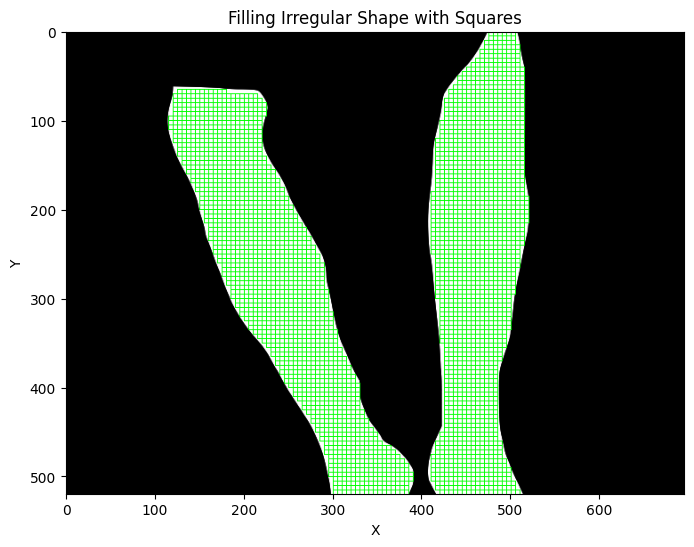

In [73]:
PNGPath = '/Users/maycaj/Downloads/EdemaTrueCrops/Edema 10 image 1 float.png'
final_squares = display_squares(True, PNGPath, square_size=5) # can't set size below 11

In [24]:
import cv2 

def png2spec(show_plot,npy,PNGPath, square_size):
    final_squares = display_squares(False, PNGPath, square_size)
    npy_patches = []
    # print(f"len(final_squares) {len(final_squares)}")
    for xvalue, yvalue, sidelength in final_squares:
        npy_patch = npy[yvalue:yvalue+sidelength, xvalue:xvalue+sidelength, :]
        npy_patches.append(npy_patch)
    # print(f"Number of npy_patches: {len(npy_patches)}")
    if show_plot:
        plt.figure(1)
        plt.figure(figsize=(20, 1))
        plt.title('Patches plotted from npy')
        for i, npy_patch in enumerate(npy_patches):
                red = npy_patch[:,:,20]
                green = npy_patch[:,:,35]
                blue = npy_patch[:,:,60]
                #Combine bands into color image
                color_patch = np.dstack((blue, green, red))
                plt.subplot(1, len(npy_patches), i+1)
                plt.imshow(color_patch)
        plt.show()
    SpectrumPatches = []
    # print(f'len(npy_patches): {len(npy_patches)}')
    patch_shape = npy_patches[0].shape
    # print(f'patch_shape: {patch_shape}')
    all_patches = np.zeros((len(npy_patches),patch_shape[0],patch_shape[1],patch_shape[2]))
    for i, npy_patch in enumerate(npy_patches):
            SpectrumPatch = np.mean(npy_patch, axis=(0,1))
            SpectrumPatches.append(SpectrumPatch)
            all_patches[i,:,:,:] = npy_patch
    avg_patch = np.mean(all_patches, axis =(0))
    # print(f'avg_patch.shape: {avg_patch.shape}')
    avg_spectrum = np.mean(avg_patch, axis=(0,1))
    # print(f'avg_spectrum.shape: {avg_spectrum.shape}')
    PNG_NP = cv2.imread(PNGPath)
    PNG_NP = PNG_NP[:, :, ::-1] # switch RGB to BGR for imshow
    # print(f'shape(PNG_NP): {PNG_NP.shape}')
    if show_plot:
        plt.figure(2)
        plt.imshow(PNG_NP)
        plt.title('PNG_NP')
        plt.figure(3)
        plt.figure(figsize = (20,1))
        for i, final_square in enumerate(final_squares):
            xvalue, yvalue, sidelength = final_square
            PNG_patch = PNG_NP[yvalue:yvalue+sidelength,xvalue:xvalue+sidelength,:]
            plt.subplot(1, len(final_squares), i+1)
            plt.imshow(PNG_patch)
        plt.show()
    return avg_spectrum, SpectrumPatches


# #define a different function if needed for 1 pixel analysis
# def png2spec(show_plot,npy,PNGPath):
#     image = cv2.imread(PNGPath, cv2.IMREAD_GRAYSCALE)
#     if image is None:
#         print(f"Error: Unable to load image from path {PNGPath}")
#     thresh = 0
#     th, image = cv2.threshold(image, thresh, 1, cv2.THRESH_BINARY)
#     if show_plot:
#          plt.imshow(image)
#     SpectrumPatches = []
#     for x in range(image.shape[0]):
#          for y in range(image.shape[1]):
#               if image[x,y] == 1:
#                    SpectrumPatches.append(npy[x,y,:])
#     spectrums = np.array(SpectrumPatches)
#     avg_spectrum = np.mean(spectrums, axis=(0))
#     return avg_spectrum, SpectrumPatches


In [63]:

avg_spectrum, SpectrumPatches = png2spec(True, npy, PNGPath, 11)

Error: Unable to load image from path /Users/maycaj/Documents/HSI_III/Patients Enrollments/EDema 2/EDema 2 Image1.png


[ WARN:0@105677.920] global loadsave.cpp:241 findDecoder imread_('/Users/maycaj/Documents/HSI_III/Patients Enrollments/EDema 2/EDema 2 Image1.png'): can't open/read file: check file path/integrity
[ WARN:0@105677.920] global loadsave.cpp:241 findDecoder imread_('/Users/maycaj/Documents/HSI_III/Patients Enrollments/EDema 2/EDema 2 Image1.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [55]:

def PlotSpectrum(AVGspectrum, SpectrumPatches):
    fig2 = plt.plot(AVGspectrum, label = 'Average Spectrum', color = 'black')
    for i, spectrum in enumerate(SpectrumPatches):
        # if i == 10:
        #     break
        if i == 1:
           fig2 = plt.plot(spectrum, color = 'g', alpha = 0.1, label = "patches")
        else:             
            fig2 = plt.plot(spectrum, color = 'g', alpha = 0.1)
    fig2 = plt.xlabel('Bands')
    fig2 = plt.ylabel('Intensity')
    fig2 = plt.legend()  
    fig2 = plt.show()


In [59]:
PlotSpectrum(avg_spectrum, SpectrumPatches)

NameError: name 'avg_spectrum' is not defined

# **Step 4:** Save the spectrum as .csv

In [13]:
def spectrum2csv(SpectrumPatches, category, CSVpath):
    for spectrum in SpectrumPatches:
        spectrum = spectrum.tolist()
        row = []
        row.append(category)
        row = row + spectrum
        # Open the CSV file in append mode ('a')
        if not os.path.exists(CSVpath): # if the .csv file does not exist yet, write the header file such that the 
            with open(CSVpath, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                header = ['Lipstick',376.61,381.55,386.49,391.43,396.39,401.34,406.3,411.27,416.24,421.22,426.2,431.19,436.18,441.17,446.17,451.18,456.19,461.21,466.23,471.25,476.28,481.32,486.36,491.41,496.46,501.51,506.57,511.64,516.71,521.78,526.86,531.95,537.04,542.13,547.23,552.34,557.45,562.57,567.69,572.81,577.94,583.07,588.21,593.36,598.51,603.66,608.82,613.99,619.16,624.33,629.51,634.7,639.88,645.08,650.28,655.48,660.69,665.91,671.12,676.35,681.58,686.81,692.05,697.29,702.54,707.8,713.06,718.32,723.59,728.86,734.14,739.42,744.71,750.01,755.3,760.61,765.92,771.23,776.55,781.87,787.2,792.53,797.87,803.21,808.56,813.91,819.27,824.63,830,835.37,840.75,846.13,851.52,856.91,862.31,867.71,873.12,878.53,883.95,889.37,894.8,900.23,905.67,911.11,916.56,922.01,927.47,932.93,938.4,943.87,949.35,954.83,960.31,965.81,971.3,976.8,982.31,987.82,993.34,998.86,1004.39,1009.92,1015.45,1020.99,1026.54,1032.09,1037.65,1043.21]
                writer.writerow(header)
        with open(CSVpath, 'a', newline='') as csvfile:
            # Create a csv writer object
            writer = csv.writer(csvfile)
            # Write the new data as a list (row)
            writer.writerow(row)
    print(f"{len(SpectrumPatches)} Spectrum patches added")
    return

CSVpath = "/Users/maycaj/Documents/HSI_III/spectrums-11-15-24.csv"
# spectrum2csv(SpectrumPatches, category, CSVpath)

# **Steps 4-7 are for batches of images**

# **Step 4:** Find all of the .png .float files in a given directory

In [74]:
mainDir = '/Users/maycaj/Documents/HSI_III/EdemaTrue/' # set the main directory
CroppedPNGDirectory = mainDir
FloatDirectory = mainDir
CSVpath = '/Users/maycaj/Documents/HSI_III/spectrums-12-1-24_EdemaTF_imgNum_5.csv'

In [75]:

def FindFilepaths(directory):
    files = os.listdir(directory)
    filepaths = []
    for file in files:
        filepath = directory + file
        filepaths.append(filepath)
        filepaths.sort()
    return filepaths
# paths = FindFilepaths("/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick_Sunscreen Images/Combined/")

def FloatHDRPaths(directory):
    AllFilepaths = FindFilepaths(directory)
    FilePaths = []
    for FilePath in AllFilepaths:
        ending = FilePath[-5:]
        if ending == 'float':
            HDRPath = FilePath[:-5] + 'hdr' 
            FilePaths.append([FilePath, HDRPath])
    return FilePaths

FilePaths = FloatHDRPaths(mainDir)
FilePaths

[['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 020 image 1 float.float',
  '/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 020 image 1 float.hdr'],
 ['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 020 image 2 float.float',
  '/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 020 image 2 float.hdr'],
 ['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 1 float.float',
  '/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 1 float.hdr'],
 ['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 2 float.float',
  '/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 2 float.hdr'],
 ['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 3 float.float',
  '/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 3 float.hdr'],
 ['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 022 image 1 float.float',
  '/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 022 image 1 float.hdr'],
 ['/Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 026 image 1 float.float',
  '/U

# **Step 5:** Create PNGs from Floats within a Folder

In [19]:
for FloatPath, HDRPath in FloatHDRPaths(FloatDirectory):
    npy, category, PNGPath = Float2NPY(HDRPath, FloatPath, CroppedPNGDirectory)
    print(PNGPath)
    npy2png(npy, PNGPath)

/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 020 image 1 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 020 image 2 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 1 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 2 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 021 image 3 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 022 image 1 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 026 image 1 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 026 image 2 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 026 image 3 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 10 Image 2 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 11 Image 2 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 11 Image 3 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 12 image 1 float.png
/Users/maycaj/Documents/HSI_III/EdemaFalse/EDema 12 image 2 float.png
/Users/mayc

# **Step 6:** Crop the PNGs in Preview

# **Step 7:** Create the CSV from all the PNGs

In [76]:
for FloatPath, HDRPath in FloatHDRPaths(FloatDirectory):
    npy, category, PNGPath = Float2NPY(HDRPath, FloatPath, CroppedPNGDirectory) # generate the npy, image categorical label, and path for png 
    print(f'Working on: {PNGPath}')
    final_squares = display_squares(False, PNGPath, square_size=5)
    if final_squares == []: 
        print(f'No squares found at: {PNGPath}')
    else: # if the image has been entirely cropped out (no useful ROI) then do not add spectrum
        AVGspectrum, SpectrumPatches = png2spec(False, npy, PNGPath, square_size=5) # find the spectrums from images and PNGs
        spectrum2csv(SpectrumPatches, category, CSVpath) # add the spectrums to the CSV file
        print(f"Spectrum added to csv from Float path: {FloatPath}")    

Working on: /Users/maycaj/Documents/HSI_III/EdemaTrue//EDema 020 image 1 float.png
2107 Spectrum patches added
Spectrum added to csv from Float path: /Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 020 image 1 float.float
Working on: /Users/maycaj/Documents/HSI_III/EdemaTrue//EDema 020 image 2 float.png
2212 Spectrum patches added
Spectrum added to csv from Float path: /Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 020 image 2 float.float
Working on: /Users/maycaj/Documents/HSI_III/EdemaTrue//EDema 021 image 1 float.png
2136 Spectrum patches added
Spectrum added to csv from Float path: /Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 1 float.float
Working on: /Users/maycaj/Documents/HSI_III/EdemaTrue//EDema 021 image 2 float.png
2885 Spectrum patches added
Spectrum added to csv from Float path: /Users/maycaj/Documents/HSI_III/EdemaTrue/EDema 021 image 2 float.float
Working on: /Users/maycaj/Documents/HSI_III/EdemaTrue//EDema 021 image 3 float.png
No squares found at: /Users/m